In [23]:
import pandas as pd
import numpy as np
import xgboost as xgb
from math import sqrt
from math import acos
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from immuno_ms2rescore_tools.file_utilities import PrositLib


In [24]:
def load_data(vector_filename, ion_type):
    # Read file
    if vector_filename.split(".")[-1] == "pkl":
        vectors = pd.read_pickle(vector_filename)
    elif vector_filename.split(".")[-1] == "h5":
        # vectors = pd.read_hdf(vector_filename, key='table', stop=1000)
        vectors = pd.read_hdf(vector_filename, key="table")
    else:
        print("Unsuported feature vector format")
        exit(1)

    # Extract targets for given ion type
    target_names = list(vectors.columns[vectors.columns.str.contains("targets")])
    if not "targets_{}".format(ion_type) in target_names:
        print("Targets for {} could not be found in vector file.".format(ion_type))
        print("Vector file only contains these targets: {}".format(target_names))
        exit(1)

    targets = vectors.pop("targets_{}".format(ion_type))
    target_names.remove("targets_{}".format(ion_type))
    for n in target_names:
        vectors.pop(n)

    # Get psmids
    psmids = vectors.pop("psmid")

    return (vectors, targets, psmids)

In [25]:
def ms2pip_pearson(true, pred):
    """
    Return pearson of tic-normalized, log-transformed intensities, 
    the MS2PIP way.
    """
    #tic_norm = lambda x: x / np.sum(x)
    # log_transform = lambda x: np.log2(x + 0.001)
    corr = pearsonr(
        true, 
        pred
    )[0]
    return (corr)

In [26]:
def spectral_angle(true, pred, epsilon=1e-7):
    """
    Return square root normalized spectral angle.
    See https://doi.org/10.1074/mcp.O113.036475
    """
    
    de_log = lambda x: (2**x)-0.001
    l2_normalize = lambda x: x / sqrt(max(sum(x**2), epsilon))
    
    pred_norm = l2_normalize(de_log(pred))
    true_norm = l2_normalize(de_log(true))
    
    spectral_angle = 1 - (2 * acos(np.dot(pred_norm, true_norm)) / np.pi)

    return (spectral_angle)

In [27]:
class Scorer:
    def __init__(self,psmids):
        self.psmids = psmids
        
    def psm_score(self,targets, predictions):
        tmp = pd.DataFrame(columns=["psmids", "targets", "predictions"])
        tmp["psmids"] = np.array(self.psmids)
        tmp["targets"] = np.array(targets)
        tmp["predictions"] = np.array(predictions)
        tmp2 = tmp.groupby("psmids").agg({'predictions': list, 'targets': list}).reset_index()
        spectral_corr = []
        pearson_corr = []
        for spectra in range(0, len(tmp2["psmids"])):
            if len(tmp2.targets.loc[spectra]) < 2:
                continue
            spectral_corr.append(spectral_angle(np.array(tmp2.targets.loc[spectra]), np.array(tmp2.predictions.loc[spectra])))
            pearson_corr.append(ms2pip_pearson(np.array(tmp2.targets.loc[spectra]), np.array(tmp2.predictions.loc[spectra])))
        return (pearson_corr, spectral_corr, tmp2["psmids"]) 

# Loading external evaluation data & initializing models

In [28]:
proteomics_vectorsY, proteomics_targetsY, proteomics_psmidsY = load_data("data/evaluation_data/PXD008034/tryptic_test_vector.pkl", "Y")
immunopeptide_vectorsY, immunopeptide_targetsY, immunopeptide_psmidsY = load_data("data/evaluation_data/PXD005231/HLAI_test.pkl", "Y")
hlaII_vectorsY, hlaII_targetsY, hlaII_psmidsY = load_data("data/evaluation_data/PXD020011/HLAII_test.pkl", "Y")
chymotrypsin_vectorsY, chymotrypsin_targetsY, chymotrypsin_psmidsY = load_data("data/evaluation_data/PXD010154/chymotrypsin_test.pkl", "Y")

In [29]:
proteomics_testY = xgb.DMatrix(proteomics_vectorsY, label=proteomics_targetsY)
immunopeptide_testY = xgb.DMatrix(immunopeptide_vectorsY, label=immunopeptide_targetsY)
hlaII_testY = xgb.DMatrix(hlaII_vectorsY, label=hlaII_targetsY)
chymotrypsin_testY = xgb.DMatrix(chymotrypsin_vectorsY, label=chymotrypsin_targetsY)

In [30]:
print(len(immunopeptide_psmidsY.unique()))
print(len(hlaII_psmidsY.unique()))
print(len(chymotrypsin_psmidsY.unique()))


46753
23941
25980


In [31]:
proteomics_vectorsB, proteomics_targetsB, proteomics_psmidsB = load_data("data/evaluation_data/PXD008034/tryptic_test_vector.pkl", "B")
immunopeptide_vectorsB, immunopeptide_targetsB, immunopeptide_psmidsB = load_data("data/evaluation_data/PXD005231/HLAI_test.pkl", "B")
hlaII_vectorsB, hlaII_targetsB, hlaII_psmidsB = load_data("data/evaluation_data/PXD020011/HLAII_test.pkl", "B")
chymotrypsin_vectorsB, chymotrypsin_targetsB, chymotrypsin_psmidsB = load_data("data/evaluation_data/PXD010154/chymotrypsin_test.pkl", "B")


In [32]:
proteomics_testB = xgb.DMatrix(proteomics_vectorsB, label=proteomics_targetsB)
immunopeptide_testB = xgb.DMatrix(immunopeptide_vectorsB, label=immunopeptide_targetsB)
hlaII_testB = xgb.DMatrix(hlaII_vectorsB, label=hlaII_targetsB)
chymotrypsin_testB = xgb.DMatrix(chymotrypsin_vectorsB, label=chymotrypsin_targetsB)


In [33]:
Y_models = {}
B_models = {}

In [34]:
joint_Y = xgb.Booster({'nthread': 8})  
joint_Y.load_model("data/ms2pip_models/Hyperopt_joint_HCDy.xgboost")
Y_models["Immunopeptide model"] = joint_Y

joint_B = xgb.Booster({'nthread': 8})  
joint_B.load_model("data/ms2pip_models/Hyperopt_joint_HCDb.xgboost")
B_models["Immunopeptide model"] = joint_B

Non_tryptic_Y = xgb.Booster({'nthread': 8})  
Non_tryptic_Y.load_model("data/ms2pip_models/Non_tryptic_HCDy.xgboost")
Y_models["Non-tryptic immunopeptide model"] = Non_tryptic_Y

Non_tryptic_B = xgb.Booster({'nthread': 8})  
Non_tryptic_B.load_model("data/ms2pip_models/Non_tryptic_HCDb.xgboost")
B_models["Non-tryptic immunopeptide model"] = Non_tryptic_B

Immunopeptide_chymotrypsin_Y = xgb.Booster({'nthread': 8})  
Immunopeptide_chymotrypsin_Y.load_model("data/ms2pip_models/Immunopeptide_chymotrypsin_HCDy.xgboost")
Y_models["Immuno-chymotrypsin model"] = Immunopeptide_chymotrypsin_Y

Immunopeptide_chymotrypsin_B = xgb.Booster({'nthread': 8})  
Immunopeptide_chymotrypsin_B.load_model("data/ms2pip_models/Immunopeptide_chymotrypsin_HCDb.xgboost")
B_models["Immuno-chymotrypsin model"] = Immunopeptide_chymotrypsin_B

In [35]:
Models = []
Models.extend(Y_models.keys())
Models

['Immunopeptide model',
 'Non-tryptic immunopeptide model',
 'Immuno-chymotrypsin model']

# Loading predictions of the 2019 HCD model

In [36]:
ms2pip_proteomics = pd.read_csv("data/evaluation_data/PXD008034/HCD_PXD008034_Ecoli_HCD_pred_and_emp.csv")
ms2pip_proteomics_Y = ms2pip_proteomics[ms2pip_proteomics["ion"] == "Y"]
ms2pip_proteomics_B = ms2pip_proteomics[ms2pip_proteomics["ion"] == "B"]
ms2pip_proteomics_Y = ms2pip_proteomics_Y.drop([ 'charge','ion', 'ionnumber',"mz", "rt"], axis=1)
ms2pip_proteomics_B = ms2pip_proteomics_B.drop([ 'charge','ion', 'ionnumber',"mz", "rt"], axis=1)

ms2pip_immunopeptide = pd.read_csv("data/evaluation_data/PXD005231/spec_lib_PXD005231_HCD_pred_and_emp.csv")
ms2pip_immunopeptide_Y = ms2pip_immunopeptide[ms2pip_immunopeptide["ion"] == "Y"]
ms2pip_immunopeptide_B = ms2pip_immunopeptide[ms2pip_immunopeptide["ion"] == "B"]
ms2pip_immunopeptide_Y = ms2pip_immunopeptide_Y.drop([ 'charge','ion', 'ionnumber',"mz"], axis=1)
ms2pip_immunopeptide_B = ms2pip_immunopeptide_B.drop([ 'charge','ion', 'ionnumber',"mz"], axis=1)

ms2pip_hlaII = pd.read_csv("data/evaluation_data/PXD020011/spec_lib_pxd020011_HCD_pred_and_emp.csv")
ms2pip_hlaII_Y = ms2pip_hlaII[ms2pip_hlaII["ion"] == "Y"]
ms2pip_hlaII_B = ms2pip_hlaII[ms2pip_hlaII["ion"] == "B"]
ms2pip_hlaII_Y = ms2pip_hlaII_Y.drop([ 'charge','ion', 'ionnumber',"mz"], axis=1)
ms2pip_hlaII_B = ms2pip_hlaII_B.drop([ 'charge','ion', 'ionnumber',"mz"], axis=1)

ms2pip_chymotrypsin = pd.read_csv("data/evaluation_data/PXD010154/test_spec_lib_PXD010154_HCD2019_pred_and_emp.csv")
ms2pip_chymotrypsin_Y = ms2pip_chymotrypsin[ms2pip_chymotrypsin["ion"] == "Y"]
ms2pip_chymotrypsin_B = ms2pip_chymotrypsin[ms2pip_chymotrypsin["ion"] == "B"]
ms2pip_chymotrypsin_Y = ms2pip_chymotrypsin_Y.drop([ 'charge','ion', 'ionnumber',"mz"], axis=1)
ms2pip_chymotrypsin_B = ms2pip_chymotrypsin_B.drop([ 'charge','ion', 'ionnumber',"mz"], axis=1)

# Calculate scores for 2019 HCD model predictions

In [37]:
proteomics_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
proteomics_current_model = Scorer(ms2pip_proteomics_Y["spec_id"])
proteomics_test["pearson correlation"], proteomics_test["spectral angle"],proteomics_test["psmid"]  = proteomics_current_model.psm_score(ms2pip_proteomics_Y["target"],ms2pip_proteomics_Y["prediction"])
proteomics_test["evaluation data set"] = "shotgun proteomics"

immunopeptide_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
immunopeptide_current_model = Scorer(ms2pip_immunopeptide_Y["spec_id"])
immunopeptide_test["pearson correlation"], immunopeptide_test["spectral angle"], immunopeptide_test["psmid"] = immunopeptide_current_model.psm_score(ms2pip_immunopeptide_Y["target"],ms2pip_immunopeptide_Y["prediction"])
immunopeptide_test["evaluation data set"] = "HLA-I"

hlaII_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
hlaII_test_current_model = Scorer(ms2pip_hlaII_Y["spec_id"])
hlaII_test["pearson correlation"], hlaII_test["spectral angle"], hlaII_test["psmid"] = hlaII_test_current_model.psm_score(ms2pip_hlaII_Y["target"],ms2pip_hlaII_Y["prediction"])
hlaII_test["evaluation data set"] = "HLA-II"

chymotrypsin_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
chymotrypsin_current_model = Scorer(ms2pip_chymotrypsin_Y["spec_id"])
chymotrypsin_test["pearson correlation"], chymotrypsin_test["spectral angle"], chymotrypsin_test["psmid"] = chymotrypsin_current_model.psm_score(ms2pip_chymotrypsin_Y["target"],ms2pip_chymotrypsin_Y["prediction"])
chymotrypsin_test["evaluation data set"] = "chymotrypsin-digested"

Current_model_perfY = pd.concat([proteomics_test, immunopeptide_test, hlaII_test, chymotrypsin_test])
Current_model_perfY["Model"] = "2019 HCD model"
Current_model_perfY["ion"] = "y"

/home/arthur/miniconda3/envs/ms2pip-dev/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [38]:
proteomics_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
proteomics_current_model = Scorer(ms2pip_proteomics_B["spec_id"])
proteomics_test["pearson correlation"], proteomics_test["spectral angle"],proteomics_test["psmid"] = proteomics_current_model.psm_score(ms2pip_proteomics_B["target"],ms2pip_proteomics_B["prediction"])
proteomics_test["evaluation data set"] = "shotgun proteomics"

immunopeptide_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
immunopeptide_current_model = Scorer(ms2pip_immunopeptide_B["spec_id"])
immunopeptide_test["pearson correlation"], immunopeptide_test["spectral angle"],immunopeptide_test["psmid"] = immunopeptide_current_model.psm_score(ms2pip_immunopeptide_B["target"],ms2pip_immunopeptide_B["prediction"])
immunopeptide_test["evaluation data set"] = "HLA-I"

hlaII_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
hlaII_test_current_model = Scorer(ms2pip_hlaII_B["spec_id"])
hlaII_test["pearson correlation"], hlaII_test["spectral angle"], hlaII_test["psmid"] = hlaII_test_current_model.psm_score(ms2pip_hlaII_B["target"],ms2pip_hlaII_B["prediction"])
hlaII_test["evaluation data set"] = "HLA-II"

chymotrypsin_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
chymotrypsin_current_model = Scorer(ms2pip_chymotrypsin_B["spec_id"])
chymotrypsin_test["pearson correlation"], chymotrypsin_test["spectral angle"], chymotrypsin_test["psmid"] = chymotrypsin_current_model.psm_score(ms2pip_chymotrypsin_B["target"],ms2pip_chymotrypsin_B["prediction"])
chymotrypsin_test["evaluation data set"] = "chymotrypsin-digested"

Current_model_perfB = pd.concat([proteomics_test, immunopeptide_test, hlaII_test, chymotrypsin_test])
Current_model_perfB["Model"] = "2019 HCD model"
Current_model_perfB["ion"] = "b"

In [39]:
performance_evaluation_ms2pip = pd.concat([Current_model_perfY, Current_model_perfB])

# Loading Prosit predictions

In [40]:
myprositlib_pxd008034 = PrositLib("data/evaluation_data/PXD008034/myPrositLib_PXD008034.csv")
myprositlib_pxd008034.merge_spec_ids("data/evaluation_data/PXD008034/PXD008034_prosit.csv")
prosit_proteomics = myprositlib_pxd008034.create_pred_and_emp_csv("data/evaluation_data/PXD008034/HCD_PXD008034_Ecoli_HCD_pred_and_emp.csv")
prosit_proteomics_Y = prosit_proteomics[prosit_proteomics["ion"] == "Y"]
prosit_proteomics_B = prosit_proteomics[prosit_proteomics["ion"] == "B"]

myprositlib_pxd005231 = PrositLib("data/evaluation_data/PXD005231/myPrositLib_PXD005231.csv")
myprositlib_pxd005231.remove_carbamidomethyl()
myprositlib_pxd005231.merge_spec_ids("data/evaluation_data/PXD005231/PXD005231_prosit.csv")
prosit_immunopeptide = myprositlib_pxd005231.create_pred_and_emp_csv("data/evaluation_data/PXD005231/spec_lib_PXD005231_HCD_pred_and_emp.csv")
prosit_immunopeptide_Y = prosit_immunopeptide[prosit_immunopeptide["ion"] == "Y"]
prosit_immunopeptide_B = prosit_immunopeptide[prosit_immunopeptide["ion"] == "B"]

myprositlib_pxd020011 = PrositLib("data/evaluation_data/PXD020011/myPrositLib_PXD020011.csv")
myprositlib_pxd020011.remove_carbamidomethyl()
myprositlib_pxd020011.merge_spec_ids("data/evaluation_data/PXD020011/PXD020011_prosit.csv")
prosit_hlaII = myprositlib_pxd020011.create_pred_and_emp_csv("data/evaluation_data/PXD020011/spec_lib_pxd020011_HCD_pred_and_emp.csv")
prosit_hlaII_Y = prosit_hlaII[prosit_hlaII["ion"] == "Y"]
prosit_hlaII_B = prosit_hlaII[prosit_hlaII["ion"] == "B"]

myprositlib_pxd010154 = PrositLib("data/evaluation_data/PXD010154/myPrositLib_PXD010154.csv")
myprositlib_pxd010154.merge_spec_ids("data/evaluation_data/PXD010154/PXD010154_prosit.csv")
prosit_chymotrypsin = myprositlib_pxd010154.create_pred_and_emp_csv("data/evaluation_data/PXD010154/test_spec_lib_PXD010154_HCD2019_pred_and_emp.csv")
prosit_chymotrypsin_Y = prosit_chymotrypsin[prosit_chymotrypsin["ion"] == "Y"]
prosit_chymotrypsin_B = prosit_chymotrypsin[prosit_chymotrypsin["ion"] == "B"]


# Calculate scores for Prosit model

In [41]:
proteomics_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
proteomics_current_model = Scorer(prosit_proteomics_Y["spec_id"])
proteomics_test["pearson correlation"], proteomics_test["spectral angle"],proteomics_test["psmid"]  = proteomics_current_model.psm_score(prosit_proteomics_Y["target"],prosit_proteomics_Y["prediction"])
proteomics_test["evaluation data set"] = "shotgun proteomics"

immunopeptide_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
immunopeptide_current_model = Scorer(prosit_immunopeptide_Y["spec_id"])
immunopeptide_test["pearson correlation"], immunopeptide_test["spectral angle"], immunopeptide_test["psmid"] = immunopeptide_current_model.psm_score(prosit_immunopeptide_Y["target"],prosit_immunopeptide_Y["prediction"])
immunopeptide_test["evaluation data set"] = "HLA-I"

hlaII_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
hlaII_test_current_model = Scorer(prosit_hlaII_Y["spec_id"])
hlaII_test["pearson correlation"], hlaII_test["spectral angle"], hlaII_test["psmid"] = hlaII_test_current_model.psm_score(prosit_hlaII_Y["target"],prosit_hlaII_Y["prediction"])
hlaII_test["evaluation data set"] = "HLA-II"

chymotrypsin_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
chymotrypsin_current_model = Scorer(prosit_chymotrypsin_Y["spec_id"])
chymotrypsin_test["pearson correlation"], chymotrypsin_test["spectral angle"], chymotrypsin_test["psmid"] = chymotrypsin_current_model.psm_score(prosit_chymotrypsin_Y["target"],prosit_chymotrypsin_Y["prediction"])
chymotrypsin_test["evaluation data set"] = "chymotrypsin-digested"

Current_model_perfY = pd.concat([proteomics_test, immunopeptide_test, hlaII_test, chymotrypsin_test])
Current_model_perfY["Model"] = "Prosit model"
Current_model_perfY["ion"] = "y"

In [42]:
proteomics_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
proteomics_current_model = Scorer(prosit_proteomics_B["spec_id"])
proteomics_test["pearson correlation"], proteomics_test["spectral angle"],proteomics_test["psmid"] = proteomics_current_model.psm_score(prosit_proteomics_B["target"],prosit_proteomics_B["prediction"])
proteomics_test["evaluation data set"] = "shotgun proteomics"

immunopeptide_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
immunopeptide_current_model = Scorer(prosit_immunopeptide_B["spec_id"])
immunopeptide_test["pearson correlation"], immunopeptide_test["spectral angle"],immunopeptide_test["psmid"] = immunopeptide_current_model.psm_score(prosit_immunopeptide_B["target"],prosit_immunopeptide_B["prediction"])
immunopeptide_test["evaluation data set"] = "HLA-I"

hlaII_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
hlaII_test_current_model = Scorer(prosit_hlaII_B["spec_id"])
hlaII_test["pearson correlation"], hlaII_test["spectral angle"], hlaII_test["psmid"] = hlaII_test_current_model.psm_score(prosit_hlaII_B["target"],prosit_hlaII_B["prediction"])
hlaII_test["evaluation data set"] = "HLA-II"

chymotrypsin_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
chymotrypsin_current_model = Scorer(prosit_chymotrypsin_B["spec_id"])
chymotrypsin_test["pearson correlation"], chymotrypsin_test["spectral angle"], chymotrypsin_test["psmid"] = chymotrypsin_current_model.psm_score(prosit_chymotrypsin_B["target"],prosit_chymotrypsin_B["prediction"])
chymotrypsin_test["evaluation data set"] = "chymotrypsin-digested"

Current_model_perfB = pd.concat([proteomics_test, immunopeptide_test, hlaII_test, chymotrypsin_test])
Current_model_perfB["Model"] = "Prosit model"
Current_model_perfB["ion"] = "b"

In [43]:
performance_evaluation_prosit = pd.concat([Current_model_perfY, Current_model_perfB])

In [44]:
performance_evaluation = pd.concat([performance_evaluation_ms2pip, performance_evaluation_prosit])

# Scoring predictions of newly trained models

In [45]:
proteomics_scorerY = Scorer(proteomics_psmidsY)
immunopeptide_scorerY = Scorer(immunopeptide_psmidsY)
hlaII_scorerY = Scorer(hlaII_psmidsY)
chymotrypsin_scorerY = Scorer(chymotrypsin_psmidsY)
immunopeptide_predY = {"spec_id": immunopeptide_psmidsY, "target": immunopeptide_targetsY }

In [46]:
for model in Y_models:
    proteomics_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
    proteomics_predictions = Y_models[model].predict(proteomics_testY)
    proteomics_test["pearson correlation"], proteomics_test["spectral angle"], proteomics_test["psmid"]  = proteomics_scorerY.psm_score(proteomics_targetsY,proteomics_predictions)
    proteomics_test["evaluation data set"] = "shotgun proteomics"

    immunopeptide_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
    immunopeptide_predictions = Y_models[model].predict(immunopeptide_testY)
    immunopeptide_predY[model] = immunopeptide_predictions
    immunopeptide_test["pearson correlation"], immunopeptide_test["spectral angle"], immunopeptide_test["psmid"] = immunopeptide_scorerY.psm_score(immunopeptide_targetsY,immunopeptide_predictions)
    immunopeptide_test["evaluation data set"] = "HLA-I"

    hlaII_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
    hlaII_predictions = Y_models[model].predict(hlaII_testY)
    hlaII_test["pearson correlation"], hlaII_test["spectral angle"], hlaII_test["psmid"] = hlaII_scorerY.psm_score(hlaII_targetsY,hlaII_predictions)
    hlaII_test["evaluation data set"] = "HLA-II"

    chymotrypsin_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
    chymotrypsin_predictions = Y_models[model].predict(chymotrypsin_testY)
    chymotrypsin_test["pearson correlation"], chymotrypsin_test["spectral angle"], chymotrypsin_test["psmid"] = chymotrypsin_scorerY.psm_score(chymotrypsin_targetsY,chymotrypsin_predictions)
    chymotrypsin_test["evaluation data set"] = "chymotrypsin-digested"
    
    Current_model_perfY = pd.concat([proteomics_test, immunopeptide_test, hlaII_test, chymotrypsin_test])
    Current_model_perfY["Model"] = model
    Current_model_perfY["ion"] = "y"
    
    print(f"Done with {model}")
    performance_evaluation = performance_evaluation.append(Current_model_perfY)

Done with Immunopeptide model
Done with Non-tryptic immunopeptide model
Done with Immuno-chymotrypsin model


In [47]:
proteomics_scorerB = Scorer(proteomics_psmidsB)
immunopeptide_scorerB = Scorer(immunopeptide_psmidsB)
hlaII_scorerB = Scorer(hlaII_psmidsB)
chymotrypsin_scorerB = Scorer(chymotrypsin_psmidsB)
immunopeptide_predB = {"spec_id": immunopeptide_psmidsB, "target": immunopeptide_targetsB}

In [48]:
for model in B_models:
    proteomics_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
    proteomics_predictions = B_models[model].predict(proteomics_testB)
    proteomics_test["pearson correlation"], proteomics_test["spectral angle"], proteomics_test["psmid"] = proteomics_scorerB.psm_score(proteomics_targetsB,proteomics_predictions)
    proteomics_test["evaluation data set"] = "shotgun proteomics"

    immunopeptide_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
    immunopeptide_predictions = B_models[model].predict(immunopeptide_testB)
    immunopeptide_predB[model] = immunopeptide_predictions
    immunopeptide_test["pearson correlation"], immunopeptide_test["spectral angle"], immunopeptide_test["psmid"] = immunopeptide_scorerB.psm_score(immunopeptide_targetsB,immunopeptide_predictions)
    immunopeptide_test["evaluation data set"] = "HLA-I"

    hlaII_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
    hlaII_predictions = B_models[model].predict(hlaII_testB)
    hlaII_test["pearson correlation"], hlaII_test["spectral angle"], hlaII_test["psmid"] = hlaII_scorerB.psm_score(hlaII_targetsB,hlaII_predictions)
    hlaII_test["evaluation data set"] = "HLA-II"

    chymotrypsin_test = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
    chymotrypsin_predictions = B_models[model].predict(chymotrypsin_testB)
    chymotrypsin_test["pearson correlation"], chymotrypsin_test["spectral angle"], chymotrypsin_test["psmid"] = chymotrypsin_scorerB.psm_score(chymotrypsin_targetsB,chymotrypsin_predictions)
    chymotrypsin_test["evaluation data set"] = "chymotrypsin-digested"

    Current_model_perfY = pd.concat([proteomics_test, immunopeptide_test, hlaII_test, chymotrypsin_test])
    Current_model_perfY["Model"] = model
    Current_model_perfY["ion"] = "b"
    
    print(f"Done with {model}")
    performance_evaluation = performance_evaluation.append(Current_model_perfY)

Done with Immunopeptide model
Done with Non-tryptic immunopeptide model
Done with Immuno-chymotrypsin model


# Plotting results

In [88]:
colors_cat = ["#FFCD27", "#3cacfd", "#f55e70", "#28ea22", "#808080"] 
thesis_palette = sns.color_palette(colors_cat)

colors_dup =  ["#004A9E", "#1AA3FF"]
blues = sns.color_palette(colors_dup)

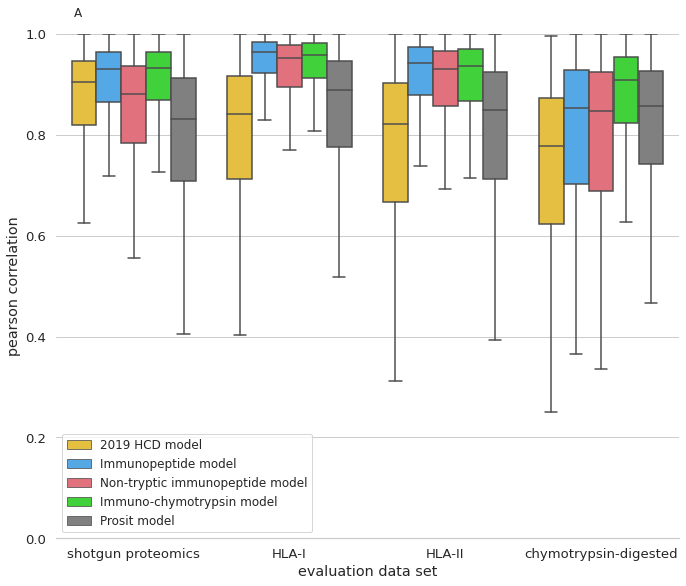

In [89]:
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)
g = sns.catplot(
x="evaluation data set",
y="pearson correlation",
hue="Model",
kind="box",
#row="ion",
showfliers=False,
data=performance_evaluation, 
palette=thesis_palette,
legend=False,
hue_order=["2019 HCD model", "Immunopeptide model", "Non-tryptic immunopeptide model", "Immuno-chymotrypsin model", "Prosit model"])

g.fig.set_size_inches(10,8)
L = plt.legend(loc='lower left', title='', prop={"size":12})
g.tight_layout()
g.despine(left=True)
g.set(ylim=(0, 1))
g.fig.suptitle('A', x=0.12,y=1.02, fontsize="small")
#plt.savefig("data/Figures/Figure1A.svg")
plt.show()


<Figure size 432x288 with 0 Axes>

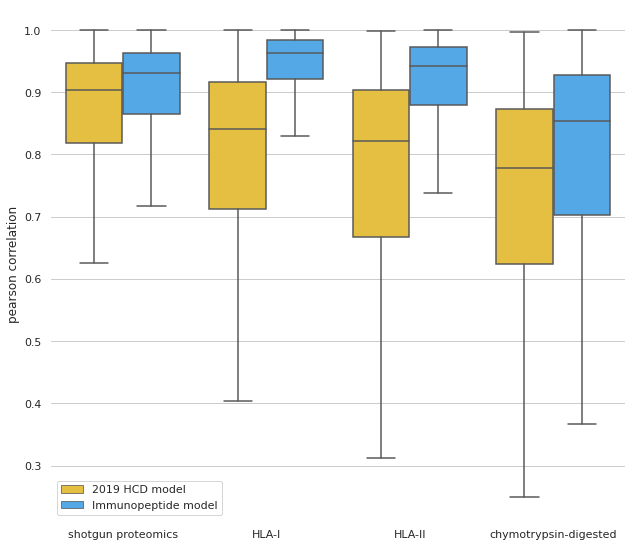

In [51]:
tmp = performance_evaluation[((performance_evaluation["Model"] == "2019 HCD model") |(performance_evaluation["Model"] == "Immunopeptide model"))]

sns.set(style="whitegrid")
sns.set_context("notebook")
fig = plt.figure()
g = sns.catplot(
x="evaluation data set",
y="pearson correlation",
hue="Model",
kind="box",
#row="ion",
showfliers=False,
data=tmp, 
palette=thesis_palette,
legend=False)
g.fig.set_size_inches(9,8)
g.tight_layout()
L = plt.legend(loc='lower left', title='')
# L.get_texts()[0].set_text("2019 HCD model")
# L.get_texts()[1].set_text("immunopeptide model")
g.despine(left=True, bottom=True)
g.set_xlabels(label="")
plt.show()

In [52]:
median_val = performance_evaluation.groupby(["Model", "ion", "evaluation data set"]).agg({"pearson correlation": "median", "spectral angle": "median"}).reset_index()

In [53]:
median_val

,Model,ion,evaluation data set,pearson correlation,spectral angle
0,2019 HCD model,b,HLA-I,0.849500,0.738534
1,2019 HCD model,b,HLA-II,0.820556,0.665068
2,2019 HCD model,b,chymotrypsin-digested,0.804478,0.648955
3,2019 HCD model,b,shotgun proteomics,0.905815,0.776623
4,2019 HCD model,y,HLA-I,0.832574,0.707239
5,2019 HCD model,y,HLA-II,0.823323,0.668655
6,2019 HCD model,y,chymotrypsin-digested,0.750965,0.588290
7,2019 HCD model,y,shotgun proteomics,0.901921,0.743854
8,Immuno-chymotrypsin model,b,HLA-I,0.951049,0.867998
9,Immuno-chymotrypsin model,b,HLA-II,0.916596,0.785539


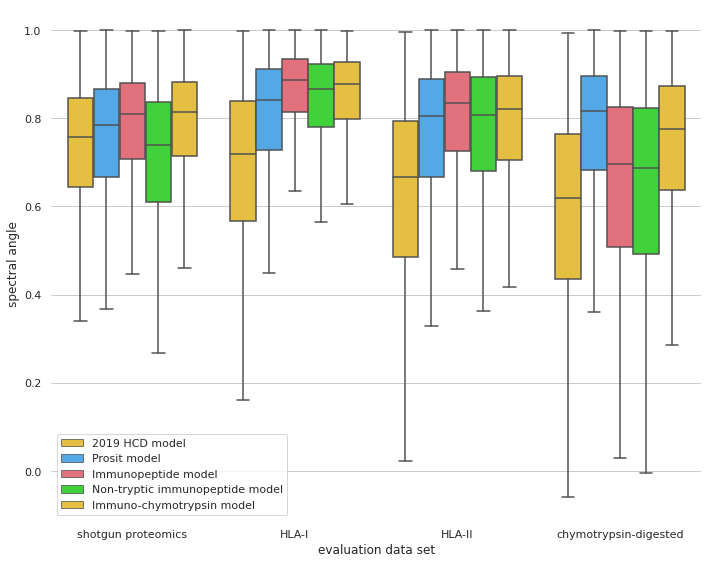

In [54]:
g = sns.catplot(
x="evaluation data set",
y="spectral angle",
hue="Model",
kind="box",
showfliers=False,
data=performance_evaluation,
palette=thesis_palette,
legend=False)
g.fig.set_size_inches(10,8)
L = plt.legend(loc='lower left', title='')
g.tight_layout()
g.despine(left=True, bottom=True)
plt.show()

# Speed of predictions for different models

In [55]:
print(len(proteomics_targetsY.unique()))
print(len(immunopeptide_targetsY.unique()))
print(len(chymotrypsin_targetsY.unique()))

331989
271974
152940


In [56]:
for model in Y_models:
    print(f"Model:{model}")
    %timeit Y_models[model].predict(proteomics_testY)
    %timeit Y_models[model].predict(immunopeptide_testY)
    %timeit Y_models[model].predict(chymotrypsin_testY)
    print("\n")

Model:Immunopeptide model
945 µs ± 6.12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
772 µs ± 3.09 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
836 µs ± 6.56 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Model:Non-tryptic immunopeptide model
950 µs ± 5.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
781 µs ± 4.14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
834 µs ± 3.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Model:Immuno-chymotrypsin model
956 µs ± 3.02 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
772 µs ± 3.22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
849 µs ± 5.94 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)




In [57]:
for model in B_models:
    print(f"Model:{model}")
    %timeit B_models[model].predict(proteomics_testB)
    %timeit B_models[model].predict(immunopeptide_testB)
    %timeit B_models[model].predict(chymotrypsin_testB)
    print("\n")

Model:Immunopeptide model
1.28 ms ± 491 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
770 µs ± 1.82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
828 µs ± 2.59 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Model:Non-tryptic immunopeptide model
943 µs ± 3.17 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
772 µs ± 2.93 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
834 µs ± 2.29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Model:Immuno-chymotrypsin model
948 µs ± 4.57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
765 µs ± 5.12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
837 µs ± 2.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)




# Tryptic vs non-tryptic predictions

In [58]:
pxd005231 = pd.read_table("data/evaluation_data/PXD005231/spec_lib_PXD005231.peprec", sep=" ")

In [59]:
pxd005231.head()

,spec_id,peptide,modifications,charge,psm_score,observed_retention_time,Label,Raw file
0,mzspec:PXD005231:20160823_QEh1_LC2_HuPa_SA_HLA...,AAAAAAAAR,-,2.0,102.000,17.164,1.0,20160823_QEh1_LC2_HuPa_SA_HLApI_RA957_1_MG_1
1,mzspec:PXD005231:20160823_QEh1_LC2_HuPa_SA_HLA...,AAAAAAAAR,-,1.0,114.940,14.600,1.0,20160823_QEh1_LC2_HuPa_SA_HLApI_RA957_2_MG_1
2,mzspec:PXD005231:20160902_QEh1_LC2_CHC_SA_HLAp...,AAAAAAAAY,-,1.0,79.935,32.866,1.0,20160902_QEh1_LC2_CHC_SA_HLApI_MD155_3
3,mzspec:PXD005231:20160823_QEh1_LC2_HuPa_SA_HLA...,AAAAAAAER,-,2.0,93.649,15.148,1.0,20160823_QEh1_LC2_HuPa_SA_HLApI_RA957_2_NG_1
4,mzspec:PXD005231:20160823_QEh1_LC2_HuPa_SA_HLA...,AAAAAAATAAR,-,2.0,70.675,23.038,1.0,20160823_QEh1_LC2_HuPa_SA_HLApI_RA957_1_MG_1


In [60]:
def tryptic_ratio(sequences):
    """
    Given a list of sequences, outputs the ratio of tryptic peptides
    """
    type_list = []
    for sequence in sequences:
        if sequence[-1] == "K" or sequence[-1] == "R":
            type_list.append("tryptic")
        else:
            type_list.append("non-tryptic")
    ratio = type_list.count("tryptic")/len(type_list)
    return ratio

In [61]:
tryptic_ratio(pxd005231.peptide)

0.22501442400153857

In [62]:
tryptic_ids = pxd005231.spec_id[((pxd005231.peptide.str.endswith("R")) | (pxd005231.peptide.str.endswith("K")))]

In [63]:
Y_predictions = pd.DataFrame(immunopeptide_predY)

In [64]:
tryptic_Y_predictions = Y_predictions[Y_predictions.spec_id.isin(tryptic_ids)]
non_tryptic_Y_predictions = Y_predictions[~(Y_predictions.spec_id.isin(tryptic_ids))]

In [65]:
B_predictions = pd.DataFrame(immunopeptide_predB)

In [66]:
tryptic_B_predictions = B_predictions[B_predictions.spec_id.isin(tryptic_ids)]
non_tryptic_B_predictions = B_predictions[~(B_predictions.spec_id.isin(tryptic_ids))]

In [67]:
new_model_pred = {
    "tryptic": {
        "y" : tryptic_Y_predictions,
        "b" : tryptic_B_predictions
    },
    "non-tryptic": {
        "y" : non_tryptic_Y_predictions,
        "b" : non_tryptic_B_predictions
    }
}
curr_model_pred = {
    "tryptic": {
        "y" : ms2pip_immunopeptide_Y[ms2pip_immunopeptide_Y.spec_id.isin(tryptic_ids)],
        "b" : ms2pip_immunopeptide_B[ms2pip_immunopeptide_B.spec_id.isin(tryptic_ids)]
    },
    "non-tryptic": {
        "y" : ms2pip_immunopeptide_Y[~(ms2pip_immunopeptide_Y.spec_id.isin(tryptic_ids))],
        "b" : ms2pip_immunopeptide_B[~(ms2pip_immunopeptide_B.spec_id.isin(tryptic_ids))]
    }
}

In [68]:
performance_peptide_type = pd.DataFrame(columns = ["pearson correlation", "spectral angle", "peptide type", "ion", "model"])
for peptide_type in new_model_pred.keys():
    for ion_type in new_model_pred[peptide_type].keys():
        psm_scorer = Scorer(curr_model_pred[peptide_type][ion_type].spec_id)
        tmp = pd.DataFrame()
        tmp["pearson correlation"], tmp["spectral angle"],_ =  psm_scorer.psm_score(curr_model_pred[peptide_type][ion_type]["prediction"],curr_model_pred[peptide_type][ion_type]["target"])
        tmp["model"] = "2019 HCD model"
        tmp["ion"] = ion_type
        tmp["peptide type"] = peptide_type
        performance_peptide_type = performance_peptide_type.append(tmp)
        
        psm_scorer = Scorer(new_model_pred[peptide_type][ion_type].spec_id)
        for model in Models:
            tmp = pd.DataFrame()
            tmp["pearson correlation"], tmp["spectral angle"],_ =  psm_scorer.psm_score(new_model_pred[peptide_type][ion_type][model],new_model_pred[peptide_type][ion_type]["target"])
            tmp["model"] = model
            tmp["ion"] = ion_type
            tmp["peptide type"] = peptide_type
            performance_peptide_type = performance_peptide_type.append(tmp)


/home/arthur/miniconda3/envs/ms2pip-dev/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


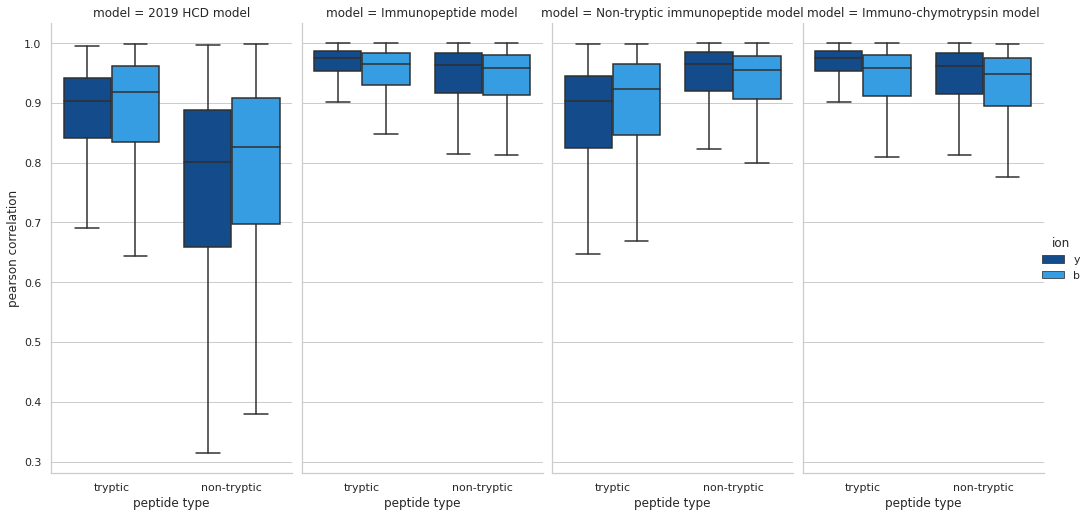

In [69]:
sns.set_style("whitegrid")
g = sns.catplot(
x="peptide type",
y="pearson correlation",
hue="ion",
kind="box",
col="model",
showfliers=False,
data=performance_peptide_type,
palette=blues)
#g.fig.suptitle("B", x= 0.1, y=1.01, weight= "medium", size="x-large")
g.fig.set_size_inches(15,8)
plt.show()

# Pearson correlation analysis based on charge & length

In [70]:
pxd005231.head()

,spec_id,peptide,modifications,charge,psm_score,observed_retention_time,Label,Raw file
0,mzspec:PXD005231:20160823_QEh1_LC2_HuPa_SA_HLA...,AAAAAAAAR,-,2.0,102.000,17.164,1.0,20160823_QEh1_LC2_HuPa_SA_HLApI_RA957_1_MG_1
1,mzspec:PXD005231:20160823_QEh1_LC2_HuPa_SA_HLA...,AAAAAAAAR,-,1.0,114.940,14.600,1.0,20160823_QEh1_LC2_HuPa_SA_HLApI_RA957_2_MG_1
2,mzspec:PXD005231:20160902_QEh1_LC2_CHC_SA_HLAp...,AAAAAAAAY,-,1.0,79.935,32.866,1.0,20160902_QEh1_LC2_CHC_SA_HLApI_MD155_3
3,mzspec:PXD005231:20160823_QEh1_LC2_HuPa_SA_HLA...,AAAAAAAER,-,2.0,93.649,15.148,1.0,20160823_QEh1_LC2_HuPa_SA_HLApI_RA957_2_NG_1
4,mzspec:PXD005231:20160823_QEh1_LC2_HuPa_SA_HLA...,AAAAAAATAAR,-,2.0,70.675,23.038,1.0,20160823_QEh1_LC2_HuPa_SA_HLApI_RA957_1_MG_1


In [71]:
pxd005231["peptide length"] = pxd005231.peptide.apply(len)
meta_info = pxd005231.filter(["spec_id", "charge", "peptide length"], axis=1).rename(columns={"spec_id": "psmid"},inplace= False)

In [72]:
performance_evaluation.head()

,pearson correlation,spectral angle,psmid,evaluation data set,Model,ion
0,0.883807,0.790242,0,shotgun proteomics,2019 HCD model,y
1,0.825382,0.695398,1,shotgun proteomics,2019 HCD model,y
2,0.920856,0.615781,2,shotgun proteomics,2019 HCD model,y
3,0.767550,0.616460,3,shotgun proteomics,2019 HCD model,y
4,0.875085,0.669169,5,shotgun proteomics,2019 HCD model,y


In [73]:
immunopeptide_performance_eval = pd.merge(performance_evaluation.loc[performance_evaluation["evaluation data set"] == "HLA-I"], meta_info, on="psmid", how="inner")

In [74]:
counts = immunopeptide_performance_eval[["charge", "peptide length", "ion"]].groupby(["charge", "ion"]).agg("count").reset_index().rename(columns={"peptide length":"count"})
counts

,charge,ion,count
0,1.0,b,38336
1,1.0,y,38336
2,2.0,b,150251
3,2.0,y,150251
4,3.0,b,41821
5,3.0,y,41821
6,4.0,b,14
7,4.0,y,14


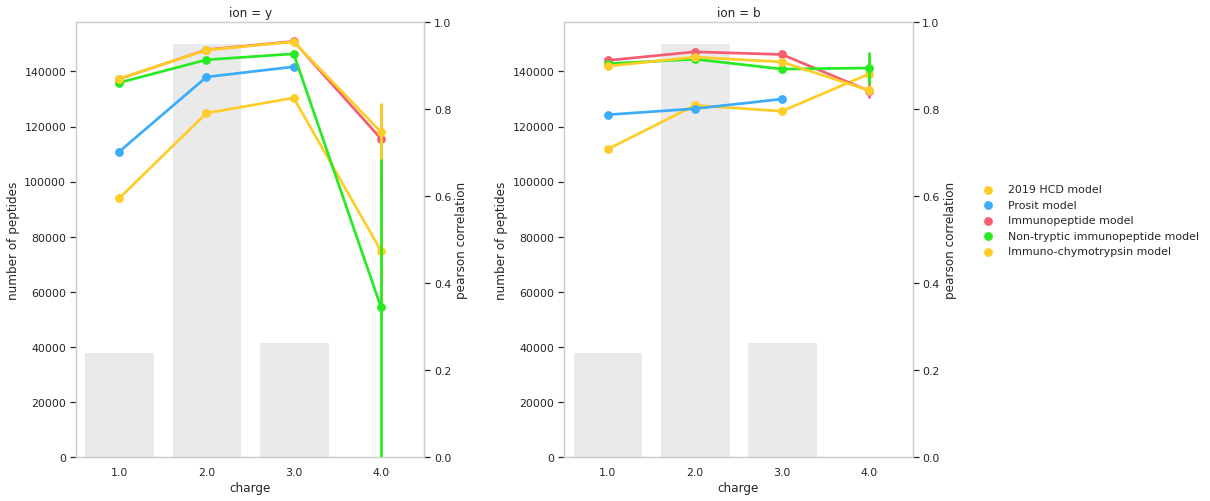

In [75]:
fig = plt.figure()
sns.set(style="whitegrid")

fig.add_subplot(121)

ax = sns.barplot(
x="charge",
y="count",
data=counts[counts.ion == "y"],
color="#EAEAEA")
ax.title.set_text("ion = y")
ax.grid(False)
ax.axes.set_ylabel("number of peptides")
ax2=ax.twinx()
ax2 = sns.pointplot(
x="charge",
y="pearson correlation",
hue="Model",
showfliers=False,
data=immunopeptide_performance_eval.loc[(immunopeptide_performance_eval.ion == "y")],
palette=thesis_palette,
legend= False)
ax2.grid(False)
#ax2.axes.set_ylabel("")
ax2.get_legend().remove()
ax2.axes.set_ylim([0,1])
fig.add_subplot(122)

ax = sns.barplot(
x="charge",
y="count",
data=counts[counts.ion == "b"],
color="#EAEAEA")
ax.axes.set_ylabel("number of peptides")
ax.grid(False)
ax.title.set_text("ion = b")
ax2=ax.twinx()
ax2 = sns.pointplot(
x="charge",
y="pearson correlation",
hue="Model",
showfliers=False,
data=immunopeptide_performance_eval.loc[(immunopeptide_performance_eval.ion == "b")],
palette=thesis_palette,
legend= False,
zorder=3.6)
ax2.grid(False)
ax2.axes.set_ylim([0,1])
ax2.legend(bbox_to_anchor=(1.85, 0.65), frameon=False)

fig.subplots_adjust(wspace=0.4)

fig.set_size_inches(15, 8)
plt.show()

In [76]:
counts = immunopeptide_performance_eval[["charge", "peptide length", "ion"]].groupby(["peptide length", "ion"]).agg("count").reset_index().rename(columns={"charge":"count"})
counts.head()

,peptide length,ion,count
0,8,b,5039
1,8,y,5039
2,9,b,141165
3,9,y,141165
4,10,b,40902


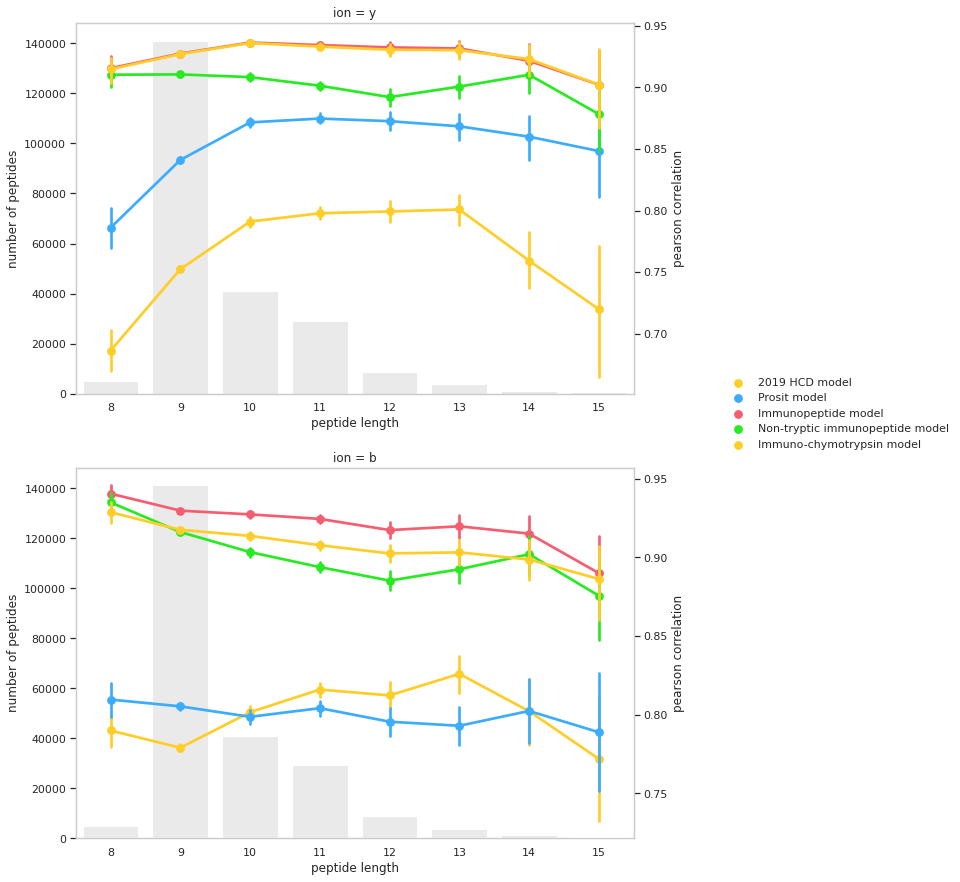

In [77]:
fig = plt.figure()
sns.set(style="whitegrid")

fig.add_subplot(211)

ax = sns.barplot(
x="peptide length",
y="count",
data=counts[counts.ion == "y"],
color="#EAEAEA")
ax.title.set_text("ion = y")
ax.axes.set_ylabel("number of peptides")
ax.grid(False)
#ax.axes.set_ylim([0,14000])
ax2=ax.twinx()
ax2 = sns.pointplot(
x="peptide length",
y="pearson correlation",
hue="Model",
showfliers=False,
data=immunopeptide_performance_eval.loc[(immunopeptide_performance_eval.ion == "y")],
palette=thesis_palette,
legend= False)
ax2.grid(False)
ax2.legend(bbox_to_anchor=(1.15, 0.07), frameon=False)

fig.add_subplot(212)

ax = sns.barplot(
x="peptide length",
y="count",
data=counts[counts.ion == "b"],
color="#EAEAEA",
zorder=2.6)
ax.grid(False)
ax.axes.set_ylabel("number of peptides")
ax.title.set_text("ion = b")
#ax.axes.set_ylim([0,14000])
ax2=ax.twinx()
ax2 = sns.pointplot(
x="peptide length",
y="pearson correlation",
hue="Model",
showfliers=False,
data=immunopeptide_performance_eval.loc[(immunopeptide_performance_eval.ion == "b")],
palette=thesis_palette,
legend= False,
zorder=3.6)
ax2.grid(False)
ax2.get_legend().remove()



fig.set_size_inches(10, 15)
plt.show()

# Chymotrypsin lenght and charge test

In [78]:
chymo_pep = pd.read_table("data/evaluation_data/PXD010154/test_spec_lib_PXD010154.peprec", sep=" ")

In [79]:
chymo_pep["peptide length"] = chymo_pep.peptide.apply(len)
meta_info = chymo_pep.filter(["spec_id", "charge", "peptide length"], axis=1).rename(columns={"spec_id": "psmid"},inplace= False)

In [80]:
chymotrypsin_perf = pd.merge(performance_evaluation.loc[performance_evaluation["evaluation data set"] == "chymotrypsin-digested"], meta_info, on="psmid", how="inner")

In [81]:
counts = chymotrypsin_perf[["charge", "peptide length", "ion"]].groupby(["charge", "ion"]).agg("count").reset_index().rename(columns={"peptide length":"count"})
counts

,charge,ion,count
0,1,b,1117
1,1,y,1117
2,2,b,27045
3,2,y,27045
4,3,b,56938
5,3,y,56939
6,4,b,24275
7,4,y,24275
8,5,b,8950
9,5,y,8951


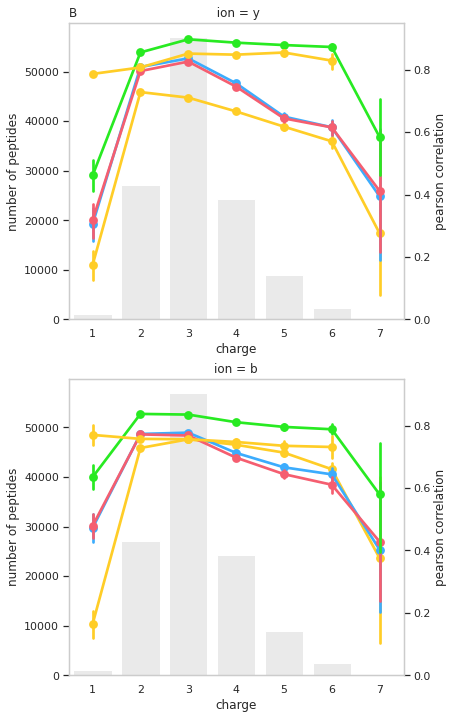

In [82]:
fig = plt.figure()
sns.set(style="whitegrid")

fig.add_subplot(211)

ax = sns.barplot(
x="charge",
y="count",
data=counts[counts.ion == "y"],
color="#EAEAEA")
ax.set_title("B                                    ion = y", loc="left")
ax.axes.set_ylabel("number of peptides")
ax.grid(False)
ax2=ax.twinx()
ax2 = sns.pointplot(
x="charge",
y="pearson correlation",
hue="Model",
showfliers=False,
data=chymotrypsin_perf.loc[(chymotrypsin_perf.ion == "y")],
palette=thesis_palette,
legend= False)
ax2.grid(False)
#ax2.axes.set_ylabel("")
ax2.get_legend().remove()
ax2.axes.set_ylim([0,0.95])
fig.add_subplot(212)

ax = sns.barplot(
x="charge",
y="count",
data=counts[counts.ion == "b"],
color="#EAEAEA")
ax.axes.set_ylabel("number of peptides")
ax.title.set_text("ion = b")
ax.grid(False)
ax2=ax.twinx()
ax2 = sns.pointplot(
x="charge",
y="pearson correlation",
hue="Model",
showfliers=False,
data=chymotrypsin_perf.loc[(chymotrypsin_perf.ion == "b")],
palette=thesis_palette,
legend= False)
ax2.axes.set_ylim([0,0.95])
ax2.get_legend().remove()
#ax2.legend(bbox_to_anchor=(1.15, 0.65), frameon=False)
ax2.grid(False)

# fig.subplots_adjust(wspace=0.4)

fig.set_size_inches(6, 12)
#plt.savefig("data/Figures/FigureS1B.svg")
plt.show()

# Pearson based on length

In [83]:
counts = chymotrypsin_perf[["charge", "peptide length", "ion"]].groupby(["peptide length", "ion"]).agg("count").reset_index().rename(columns={"charge":"count"})
counts.head()

,peptide length,ion,count
0,7,b,727
1,7,y,727
2,8,b,1625
3,8,y,1625
4,9,b,2934


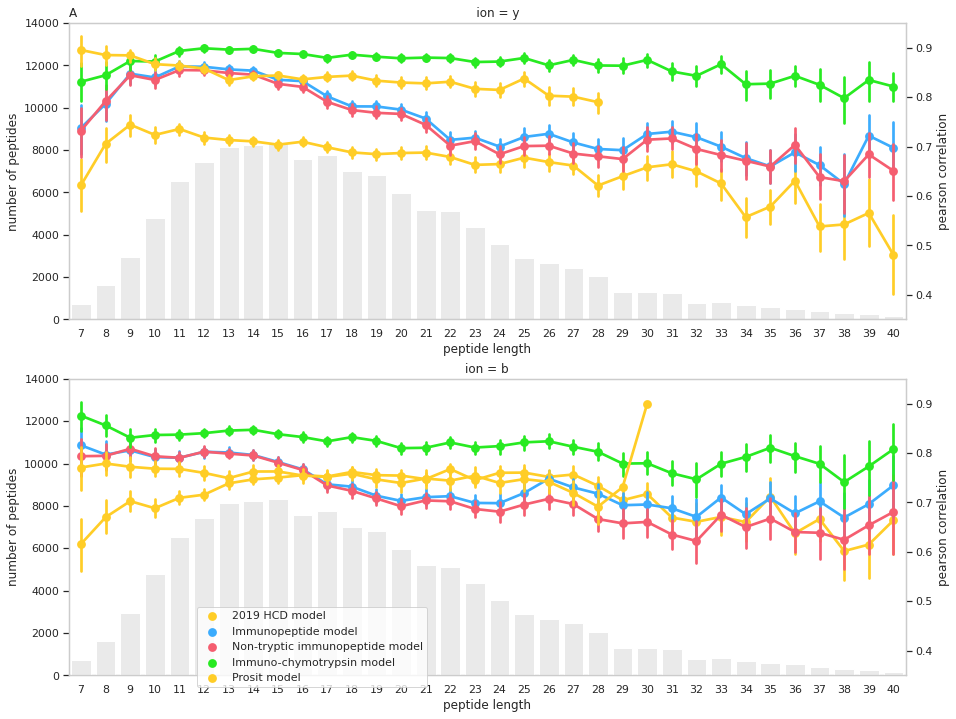

In [84]:
fig = plt.figure()
sns.set(style="whitegrid")

fig.add_subplot(211)

ax = sns.barplot(
x="peptide length",
y="count",
data=counts[counts.ion == "y"],
color="#EAEAEA")
ax.set_title("A                                                                                                       ion = y", loc="left")
ax.axes.set_ylabel("number of peptides")
ax.axes.set_ylim([0,14000])
ax.grid(False)
ax2=ax.twinx()
ax2 = sns.pointplot(
x="peptide length",
y="pearson correlation",
hue="Model",
showfliers=False,
data=chymotrypsin_perf.loc[(chymotrypsin_perf["peptide length"] <= 40) & (chymotrypsin_perf.ion == "y")],
palette=thesis_palette,
legend= False)
ax2.grid(False)
ax2.axes.set_ylim([0.35,0.95])
#ax2.legend(bbox_to_anchor=(.40, 0.30), frameon=True)
ax2.get_legend().remove()

fig.add_subplot(212)

ax = sns.barplot(
x="peptide length",
y="count",
data=counts[counts.ion == "b"],
color="#EAEAEA",
zorder=2.6)
ax.grid(False)
ax.axes.set_ylabel("number of peptides")
ax.title.set_text("ion = b")
ax.axes.set_ylim([0,14000])
ax2=ax.twinx()
ax2 = sns.pointplot(
x="peptide length",
y="pearson correlation",
hue="Model",
showfliers=False,
data=chymotrypsin_perf.loc[(chymotrypsin_perf["peptide length"] <= 40) & (chymotrypsin_perf.ion == "b")],
palette=thesis_palette,
legend= True,
zorder=3.6)
ax2.grid(False)
ax2.axes.set_ylim([0.35,0.95])
ax2.legend(bbox_to_anchor=(.435, 0.25), frameon=True)


fig.set_size_inches(15, 12)
#plt.savefig("data/Figures/FigureS1A.svg")
plt.show()

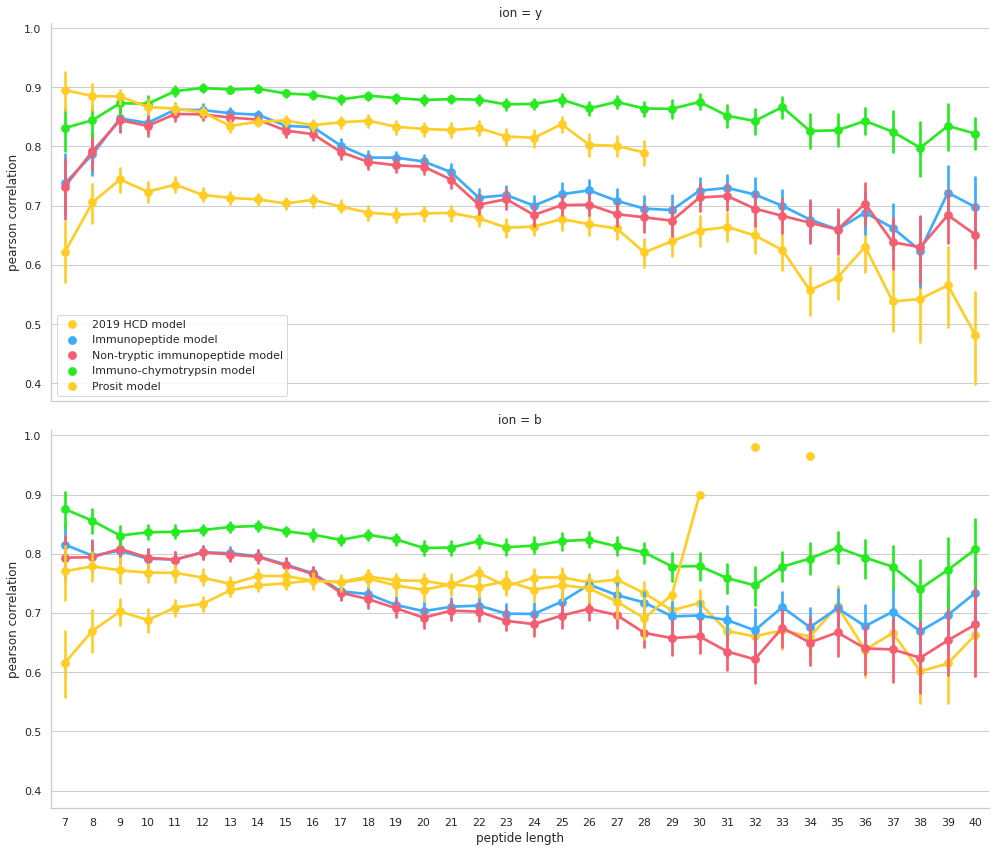

In [85]:
g = sns.catplot(
x="peptide length",
y="pearson correlation",
hue="Model",
kind="point",
row="ion",
showfliers=False,
data=chymotrypsin_perf.loc[(chymotrypsin_perf["peptide length"]<= 40)],
palette=thesis_palette,
legend_out=False
)
g.fig.set_size_inches(14,12)
g.tight_layout()
g.add_legend(loc=3)
plt.show()